In [39]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("Training Start")

# バッチサイズは1024にする。
batch_size = 2**10
# データセットの変換を定義する。平均と標準偏差を加工する。
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10のデータセットのダウンロードをする。download=Trueにすると自動的にダウンロードをする。
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print(trainset.data.shape)

Training Start
(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [40]:
# モデルの定義を行う
# f(x)=xを活性化関数とすることは何も活性化関数を入れないのと同義である。
class Model_Identity(nn.Module):
    def __init__(self, nf, nc, num_class):
        super(Model_Identity, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(nc, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.Conv2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.Conv2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.Flatten(),
            nn.Linear(nf*nf*2, num_class)
        )

    def forward(self, input):
        return self.main(input)


class Model_Sigmoid(nn.Module):
    def __init__(self, nf, nc, num_class):
        super(Model_Sigmoid, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(nc, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.Sigmoid(),
            nn.Conv2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.Sigmoid(),
            nn.Conv2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(nf*nf*2, num_class)
        )

    def forward(self, input):
        return self.main(input)


class Model_ReLU(nn.Module):
    def __init__(self, nf, nc, num_class):
        super(Model_ReLU, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(nc, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.ReLU(),
            nn.Conv2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.ReLU(),
            nn.Conv2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(nf*nf*2, num_class)
        )

    def forward(self, input):
        return self.main(input)




class Model_LeakyReLU(nn.Module):
    def __init__(self, nf, nc, num_class):
        super(Model_LeakyReLU, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(nc, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(nf*nf*2, num_class)
        )

    def forward(self, input):
        return self.main(input)

class Model_PReLU(nn.Module):
    def __init__(self, nf, nc, num_class):
        super(Model_PReLU, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(nc, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.PReLU(),
            nn.Conv2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.PReLU(),
            nn.Conv2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(nf*nf*2, num_class)
        )

    def forward(self, input):
        return self.main(input)

# FReLUの定義、畳み込み層を使うのでバッチノーマライゼーションをしたほうがいい。
class FReLU(nn.Module):
  def __init__(self,nf):
    super().__init__()
    self.main = nn.Sequential(
            nn.Conv2d(nf, nf, 3,1,1),
            nn.BatchNorm2d(nf)
        )
  def forward(self,input):
    conv_input =self.main(input)
    return torch.max(input, conv_input)

class Model_FReLU(nn.Module):
    def __init__(self, nf, nc, num_class):
        super(Model_FReLU, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(nc, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            FReLU(nf*4),
            nn.Conv2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            FReLU(nf*2),
            nn.Conv2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            FReLU(nf),
            nn.Flatten(),
            nn.Linear(nf*nf*2, num_class)
        )

    def forward(self, input):
        return self.main(input)

In [41]:
import torch

# cudaが使えるかどうかをみておく
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

nets = []
nets.append(Model_Identity(8, 3, 10).to(device))
nets.append(Model_Sigmoid(8, 3, 10).to(device))
nets.append(Model_ReLU(8, 3, 10).to(device))
nets.append(Model_LeakyReLU(8, 3, 10).to(device))
nets.append(Model_PReLU(8, 3, 10).to(device))
nets.append(Model_FReLU(8, 3, 10).to(device))


cpu


In [42]:
# 公式実装

import torch.optim as optim

# モデルごとの損失とtop1正解率を格納する。
losses_array=[]
accs_array=[]

for net in nets:

    criterion = nn.CrossEntropyLoss()
    # 確率的効果法によって学習中に柔軟に学習係数を変化させる。
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    loss_array=[]
    acc_array=[]

    for epoch in range(50):

        running_loss = 0.0
        i_save =0
        sum_epoch= 0
        for i, data in enumerate(trainloader, 0):
            i_save+=1
            # 画像と画像ラベルを読み出し、それをGPUに載せるのであれば載せる。
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 学習を進行させる。
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 損失と正解率を加算する。
            running_loss += loss.item()
            arg_1 = torch.argmax(outputs ,dim = 1)
            sum_epoch+=torch.sum(labels ==arg_1)
        # 損失と正解率を記録する。
        print(f'[{epoch + 1}, {i_save + 1:5d}] loss: {running_loss / i_save:.3f} acc: {sum_epoch / (trainset.data.shape[0]):.3f}')
        loss_array.append(running_loss / i_save)
        acc_array.append(sum_epoch / (trainset.data.shape[0]))
        
        running_loss = 0.0
        sum_epoch = 0


    print('Finished Training')
    losses_array.append(loss_array)
    accs_array.append(acc_array)

[1,    50] loss: 2.176 acc: 0.201
[2,    50] loss: 1.983 acc: 0.293
[3,    50] loss: 1.922 acc: 0.326
[4,    50] loss: 1.888 acc: 0.345
[5,    50] loss: 1.864 acc: 0.356
[6,    50] loss: 1.846 acc: 0.365
[7,    50] loss: 1.831 acc: 0.370
[8,    50] loss: 1.818 acc: 0.374
[9,    50] loss: 1.808 acc: 0.379
[10,    50] loss: 1.798 acc: 0.382
[11,    50] loss: 1.789 acc: 0.386
[12,    50] loss: 1.781 acc: 0.388
[13,    50] loss: 1.773 acc: 0.391
[14,    50] loss: 1.768 acc: 0.393
[15,    50] loss: 1.761 acc: 0.396
[16,    50] loss: 1.757 acc: 0.398
[17,    50] loss: 1.751 acc: 0.400
[18,    50] loss: 1.747 acc: 0.402
[19,    50] loss: 1.743 acc: 0.403
[20,    50] loss: 1.739 acc: 0.405
[21,    50] loss: 1.735 acc: 0.406
[22,    50] loss: 1.732 acc: 0.407
[23,    50] loss: 1.729 acc: 0.409
[24,    50] loss: 1.726 acc: 0.409
[25,    50] loss: 1.724 acc: 0.411
[26,    50] loss: 1.721 acc: 0.411
[27,    50] loss: 1.719 acc: 0.412
[28,    50] loss: 1.716 acc: 0.413
[29,    50] loss: 1.715 acc: 

In [43]:
import pickle
f = open('losses.txt', 'wb')
pickle.dump(losses_array, f)
f = open('accs.txt', 'wb')
pickle.dump(accs_array, f)

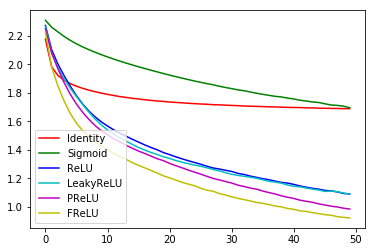

In [52]:
import matplotlib.pyplot as plt

model_labels = ["Identity", "Sigmoid", "ReLU", "LeakyReLU", "PReLU", "FReLU"]
color_labels = ["r", "g", "b", "c", "m", "y"]

x = list(range(50))

# plt.legend()

for i in range(len(losses_array)):
    plt.plot(x, losses_array[i], label = model_labels[i], color = color_labels[i])
plt.legend()
plt.savefig("loss.png")


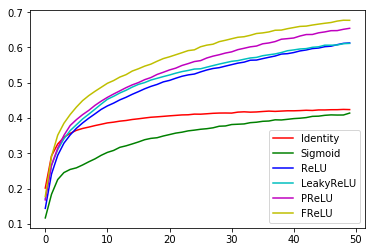

In [53]:
for i in range(len(accs_array)):
    plt.plot(x, accs_array[i], label = model_labels[i], color = color_labels[i])
plt.legend()
plt.savefig("acc.png")
